# References

Kaggle for data: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download and Jeff Prosise: https://github.com/jeffprosise/Deep-Learning/blob/master/Fraud%20Detection.ipynb 

At the end of the Lab, students should be able to

1. Use spaCy to examine PoS tags of a sentence.
2. Perform binary classification using a simple neural network.

In [ ]:
!python3 -m spacy download sv_core_news_sm

In [41]:
import spacy
from spacy.lang.sv.examples import sentences 

nlp = spacy.load("sv_core_news_sm")
doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)

2022-11-21 11:23:02.476655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 11:23:03.612696: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-21 11:23:03.612763: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-11-21 11:23:03.612769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Apple överväger att köpa brittisk startup för 1 miljard dollar.
Apple NOUN nsubj
överväger VERB csubj
att PART mark
köpa VERB ccomp
brittisk ADJ amod
startup NOUN obj
för ADP case
1 NUM nummod
miljard NOUN obl
dollar NOUN ROOT
. PUNCT punct


Binary Classification example using creditcard dataset:

In [42]:
import pandas as pd

df = pd.read_csv('creditcard.csv')
df = df.dropna()
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [43]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [44]:
from sklearn.model_selection import train_test_split

x = df.drop(['Time', 'Class'], axis=1)    # drop these 2 columns
y = df['Class']                           # assign labels to y

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

For an example diagram of a neural network, see https://www.v7labs.com/blog/neural-network-architectures-guide 




In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential() 
model.add(Dense(128, activation='relu', input_dim=29))    # Activation function defines the output of that node given an input or set of inputs
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # Optimizer is an algorithm that modifies the attributes of the neural network, such as weights and learning rate, to reduce the loss and improve the accuracy
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3840      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


2022-11-21 11:23:14.044973: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 11:23:14.045509: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-11-21 11:23:14.045606: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-21 11:23:14.045909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI D

In [46]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=100)

Epoch 1/10
2279/2279 [==============================] - 4s 1ms/step - loss: 0.0905 - accuracy: 0.9930 - val_loss: 0.0053 - val_accuracy: 0.9993
Epoch 2/10
2279/2279 [==============================] - 3s 1ms/step - loss: 0.0100 - accuracy: 0.9992 - val_loss: 0.0055 - val_accuracy: 0.9991
Epoch 3/10
2279/2279 [==============================] - 3s 1ms/step - loss: 0.0085 - accuracy: 0.9992 - val_loss: 0.0226 - val_accuracy: 0.9993
Epoch 4/10
2279/2279 [==============================] - 3s 1ms/step - loss: 0.0081 - accuracy: 0.9993 - val_loss: 0.0063 - val_accuracy: 0.9993
Epoch 5/10
2279/2279 [==============================] - 3s 1ms/step - loss: 0.0067 - accuracy: 0.9994 - val_loss: 0.0091 - val_accuracy: 0.9993
Epoch 6/10
2279/2279 [==============================] - 3s 1ms/step - loss: 0.0067 - accuracy: 0.9994 - val_loss: 0.0097 - val_accuracy: 0.9994
Epoch 7/10
2279/2279 [==============================] - 3s 1ms/step - loss: 0.0088 - accuracy: 0.9994 - val_loss: 0.0087 - val_accuracy:

[]

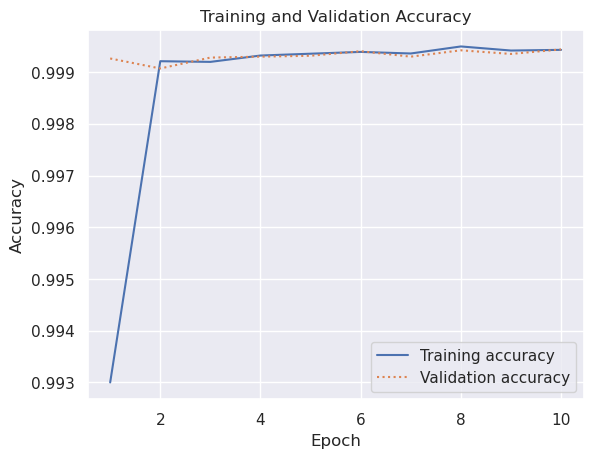

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

1781/1781 [==============================] - 1s 482us/step


Text(109.44999999999997, 0.5, 'Actual label')

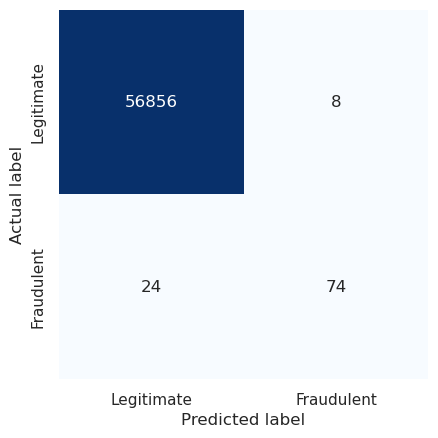

In [48]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(x_test) > 0.5
mat = confusion_matrix(y_test, y_predicted)
labels = ['Legitimate', 'Fraudulent']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

Task

1. Perform binary classification on the IMDB dataset. Report your accuracy after 15 epochs and draw the confusion matrix to show the error analysis.
2. Repeat 1 using a different activation function from RELU and a different optimizer.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from nltk.corpus import stopwords
from nltk import word_tokenize
import pandas as pd

In [22]:
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers
    for index, row in data.iterrows():
        if index % 5000 == 0:
            print(index)
        word_tokens = word_tokenize(row['Sentence'])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        new_df =pd.DataFrame({"Class": row['Class'], "Sentence": " ".join(filtered_sent[0:])},index=[0])
        df_ = pd.concat([new_df, df_.loc[:]]).reset_index(drop=True)
        # df_ = df_.concat({
        #     "Class": row['Class'],
        #     "Sentence": " ".join(filtered_sent[0:])
        # }, ignore_index=True)
    return data

In [23]:
# Load preprocessed data (preprocessed by the function above)
data = pd.read_csv("IMDB Dataset.csv", delimiter=',', header=None)
data.columns = ['Sentence', 'Class']
data['Class'] = data['Class'].replace("positive", 1)
data['Class'] = data['Class'].replace("negative", 0)
columns = ['Sentence', 'Class']
data = preprocess_pandas(data, columns) # pre-process

/tmp/ipykernel_3457/4177502960.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [24]:
data = data.iloc[1:]

In [25]:
from sklearn.model_selection import train_test_split

training_data, validation_data, training_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
    data['Sentence'].values.astype('U'),
    data['Class'].values.astype('int32'),
    test_size=0.20,
    random_state=0,
    shuffle=True
)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=5000, max_df=0.5, use_idf=True, norm='l2')
training_data = word_vectorizer.fit_transform(training_data)        # transform texts to sparse matrix
training_data = training_data.todense()                             # convert to dense matrix for Pytorch
vocab_size = len(word_vectorizer.vocabulary_) 
validation_data = word_vectorizer.transform(validation_data)
validation_data = validation_data.todense()
train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
train_y_tensor = torch.from_numpy(np.array(training_labels)).long()
validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()

In [30]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_dataset = TensorDataset(validation_x_tensor, validation_y_tensor)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

In [32]:
network = nn.Sequential(
    nn.Linear(vocab_size, 256),
    nn.ReLU(),
    nn.Linear(256, 100), 
    nn.ReLU(), 
    nn.Linear(100, 2)
)

optimizer = torch.optim.Adam(network.parameters())

loss_function = torch.nn.CrossEntropyLoss()

epochs = 15

to_onehot = nn.Embedding.from_pretrained(torch.eye(2))

for epoch in range(epochs):
    for batch_nr, (data, labels) in enumerate(train_loader):
        prediction = network(data)
        loss = loss_function(prediction, to_onehot(labels))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(
            f'\rEpoch {epoch+1} [{batch_nr+1}/{len(train_loader)}] - Loss: {loss}',
            end='')

Epoch 15 [800/800] - Loss: 0.0167054869234561922

In [33]:
with torch.no_grad():
    classes = [0, 1]
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    for batch_nr, (data, labels) in enumerate(val_loader):
        prediction = network(data)
        for i in range(len(prediction)):
            y_pred.append(torch.argmax(prediction[i]))
            y_true.append(labels[i])
            if y_pred[-1] == y_true[-1]:
                correct += 1
            total += 1
            
    print(f'The accuracy of the network is {str(100*correct/total)[:4]}%.')

The accuracy of the network is 87.0%.


Text(113.9222222222222, 0.5, 'Actual label')

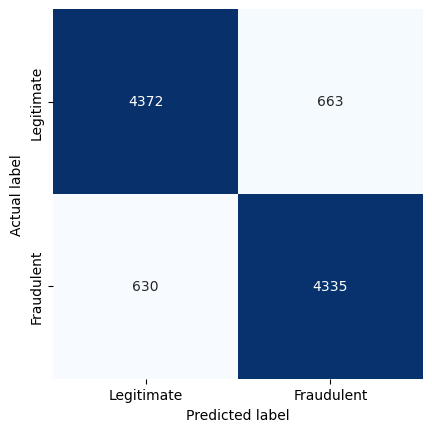

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

mat = confusion_matrix(y_true, y_pred)
labels = ['Legitimate', 'Fraudulent']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

# RUN TWO

In [39]:
network = nn.Sequential(
    nn.Linear(vocab_size, 256),
    nn.GELU(),
    nn.Linear(256, 100), 
    nn.GELU(), 
    nn.Linear(100, 2)
)

optimizer = torch.optim.RMSprop(network.parameters())

loss_function = torch.nn.CrossEntropyLoss()

epochs = 15

to_onehot = nn.Embedding.from_pretrained(torch.eye(2))

for epoch in range(epochs):
    for batch_nr, (data, labels) in enumerate(train_loader):
        prediction = network(data)
        loss = loss_function(prediction, to_onehot(labels))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(
            f'\rEpoch {epoch+1} [{batch_nr+1}/{len(train_loader)}] - Loss: {loss}',
            end='')

with torch.no_grad():
    classes = [0, 1]
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    for batch_nr, (data, labels) in enumerate(val_loader):
        prediction = network(data)
        for i in range(len(prediction)):
            y_pred.append(torch.argmax(prediction[i]))
            y_true.append(labels[i])
            if y_pred[-1] == y_true[-1]:
                correct += 1
            total += 1
            
    print(f'The accuracy of the network is {str(100*correct/total)[:4]}%.')

Epoch 15 [800/800] - Loss: 4.970419468008913e-066The accuracy of the network is 87.4%.


Text(113.9222222222222, 0.5, 'Actual label')

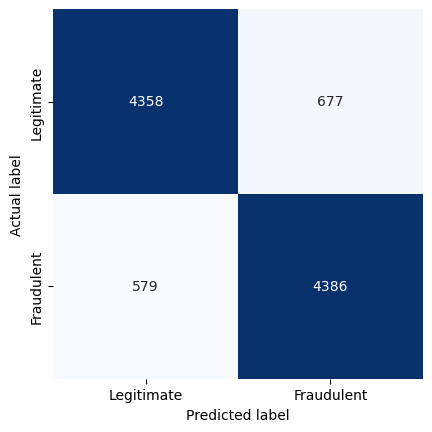

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

mat = confusion_matrix(y_true, y_pred)
labels = ['Legitimate', 'Fraudulent']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

Grading questions (in addition to any relevant ones not listed below):

1. Run your code, go through it and explain what it does.
2. Is there any part of the code that may be optimized (made better)
3. What other challenges can this solution be adapted for?
4. Will you like to discuss the time & space complexities of parts of your solution (optional)?